In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor

from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve

![CDC Logo](https://www.hamiltoncountyhealth.org/wp-content/uploads/cdc-logo.png) <br>
# Tackling Flu and Vaccine Misinformation for the CDC
The mission statement of the CDC is ***"to promote health and quality of life by preventing and controlling disease, injury, and disability."*** <br>
And so, an integral part of fulfilling this mission is to provide the population with the appropriate infromation that is needed in order to make the best informed decisions for their health. <br>
Disease and vaccine misinformation are a major hurdle for the CDC because lack of information or knowledge of the wrong information can lead to misinformed decisions that will compromise not onlyt a single individual's health and safety but the population's as well.
<br>
The main goal of our project is to predict what features are most influential in determining a respondent's knowledge of the H1N1 flu and vaccine.

## Data and Limitations
The data that we will be working with in this project comes from the [DataDriven](https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/) website. This data is a survey response from 2009. <br>
Since this data is from a survey response, it does not give an accurate reflection of the situation and community at the time. The data also has a pretty obvious class imbalance and some clear biases.<br> 
*(I think this can go under the recommendations) We will aim to address these biases in our project and will avoid making broad generalizations of the population based on these metrics; however, these metrics may be points of consdieration for the CDC in the future. 
Instead of making generalizations based on these metrics, we recognize that the survey response data is skewed and the CDC can aim efforts and resources to equalize the response data in order to get the most accurate representation of the US population.*

## Loading in the Data and some initial EDA
We are looking at the vaccine data from 2009 about H1N1 flu and vaccine awareness. The purpose of our project is to create a campaign for the CDC that will identify the most important features in predicting whether or not a respondent is knowledgeable or not about the H1N1 flu and vaccine.

In [2]:
# Loading in the pre-split datasets that were given to us
vaccinetrainingdf = pd.read_csv("data/training_set_features.csv")
vaccinetestdf = pd.read_csv("data/test_set_features.csv")
vaccinelabelsdf = pd.read_csv("data/training_set_labels.csv")

In [3]:
# Initial checking to see what data types we are working with as well as to see if we had any missing data
vaccinetrainingdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

As we can see there are some missing values, and some of the values are objects. Since some of the values in these columns are objects, we know that we have to one hot encode the values in order to implement them mathematically into our models.

In [4]:
vaccinetrainingdf.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
# We see here that the data is already split almost exactly in half for our training and test data sets
vaccinetestdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

In [6]:
# Utilizing this block of code just to display all the columns and their respective values
pd.set_option('max_columns', None)
vaccinetestdf.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [7]:
vaccinelabelsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


Next, we're going to be doing some data cleaning to get rid of any extraneous columns that are not relevant to our business problem of tackling misinformation in flu and vaccine awareness.

In [8]:
# Dropping data we deemed unnecessary and irrelevant to our business problem
columns_to_drop = ['respondent_id','h1n1_knowledge', 'employment_occupation', 'employment_industry', 'household_children', 'household_adults', 'census_msa', 'hhs_geo_region',
                    'employment_status', 'rent_or_own', 'marital_status', 'opinion_seas_sick_from_vacc', 'opinion_seas_risk', 'health_insurance', 'child_under_6_months',
                    'health_worker']
X_train = vaccinetrainingdf.copy().drop(columns_to_drop, axis = 1)
X_test = vaccinetestdf.copy().drop(columns_to_drop, axis = 1)
y_train = vaccinetrainingdf['h1n1_knowledge']
y_test = vaccinetestdf['h1n1_knowledge']

In [9]:
# Checking our data again to see that we dropped the irrelevant columns. We went from 34 columns to 20 columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_h1n1             24547 non-null  float64
 9   doctor_recc_seasonal         24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  opinion_h1n1_vacc_effective  26316 non-null  float64
 12  opinion_h1n1_risk            26319 non-null  float64
 13  opinion_h1n1_sic

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26623 non-null  float64
 1   behavioral_antiviral_meds    26629 non-null  float64
 2   behavioral_avoidance         26495 non-null  float64
 3   behavioral_face_mask         26689 non-null  float64
 4   behavioral_wash_hands        26668 non-null  float64
 5   behavioral_large_gatherings  26636 non-null  float64
 6   behavioral_outside_home      26626 non-null  float64
 7   behavioral_touch_face        26580 non-null  float64
 8   doctor_recc_h1n1             24548 non-null  float64
 9   doctor_recc_seasonal         24548 non-null  float64
 10  chronic_med_condition        25776 non-null  float64
 11  opinion_h1n1_vacc_effective  26310 non-null  float64
 12  opinion_h1n1_risk            26328 non-null  float64
 13  opinion_h1n1_sic

## Feature Engineering
Created some frequently used functions that we will be utilizing throughout our project

In [11]:
# Defined a OneHotEncoder function for ease of access
def OHE(X_train, categories):
    onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
    x_train_cat = pd.DataFrame(onehot.fit_transform(X_train[categories]))
    x_train_cat.columns = onehot.get_feature_names(categories)
    # Reset indices to avoid merging conflicts
    x_train_cat.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    # Joined the OHE dataframe to the dataframe that is passed into the function
    x_train_df = X_train.drop(categories, axis = 1).join(x_train_cat)
    return x_train_df

# Defined a function that takes in parameters to evaluate our models and then print out a confusion matrix for easier visualization
def confusion_and_metrics(model, X_test, y_test, y_pred):
    # Accuracy Score
    print(f"Accuracy Score: {model.score(X_test, y_test):.3f}")
    # Precision Score
    print(f"Precision Score: {precision_score(y_test, y_pred):.3f}")
    # Plot confusion matrix for visualization
    plot_confusion_matrix(model, X_test, y_test);
    

In [12]:
X_train

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,3.0,1.0,1.0,4.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,65+ Years,12 Years,White,Female,Below Poverty
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,55 - 64 Years,Some College,White,Female,NaN
26705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.0,1.0,2.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


Prior to running some classification models on our data, we looked at it again and noticed that there were still a couple missing values. In order to rectify this, we created a simple imputer to replace the NaN values with the most frequent value(otherwise known as the mode) in its respective column. We chose to use the mode to replace these NaN values because using the mode will keep the distribution of the data consistent.

In [13]:
# Created a SimpleImputer to replace the NaN values with the most_frequent(mode) values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'most_frequent')
imputed_X_train = imputer.fit_transform(X_train)
imputed_X_train_df = pd.DataFrame(imputed_X_train)

In [14]:
imputed_X_test = imputer.transform(X_test)
imputed_X_test_df = pd.DataFrame(imputed_X_test)
imputed_X_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,0,1,0,1,1,0,1,0,0,0,5,1,1,5,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000"
1,1,0,0,0,0,0,0,0,0,0,0,4,1,1,4,18 - 34 Years,12 Years,White,Male,Below Poverty
2,2,0,0,1,1,1,1,1,0,0,0,5,4,2,5,55 - 64 Years,College Graduate,White,Male,"> $75,000"
3,1,0,0,0,0,0,0,0,1,1,1,4,2,2,4,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty"
4,3,1,1,0,1,1,1,1,0,0,0,5,2,4,4,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,1,0,1,0,1,0,0,1,1,1,0,4,2,2,4,35 - 44 Years,College Graduate,White,Female,"<= $75,000, Above Poverty"
26704,3,0,1,0,1,1,1,1,0,0,0,4,1,1,5,18 - 34 Years,12 Years,White,Male,Below Poverty
26705,0,0,0,0,0,0,0,0,0,0,0,4,3,1,4,18 - 34 Years,Some College,White,Female,Below Poverty
26706,3,0,1,0,1,0,1,0,0,0,0,2,3,4,4,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"


In [15]:
# After doing the imputation and renaming, checked to see if the counts of the values in all columns was the same
imputed_X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       26708 non-null  object
 1   1       26708 non-null  object
 2   2       26708 non-null  object
 3   3       26708 non-null  object
 4   4       26708 non-null  object
 5   5       26708 non-null  object
 6   6       26708 non-null  object
 7   7       26708 non-null  object
 8   8       26708 non-null  object
 9   9       26708 non-null  object
 10  10      26708 non-null  object
 11  11      26708 non-null  object
 12  12      26708 non-null  object
 13  13      26708 non-null  object
 14  14      26708 non-null  object
 15  15      26708 non-null  object
 16  16      26708 non-null  object
 17  17      26708 non-null  object
 18  18      26708 non-null  object
 19  19      26708 non-null  object
dtypes: object(20)
memory usage: 4.1+ MB


After imputing the data, we recognize that the column names have disappeared but the indices are still there. To resolve this, we create a dictionary with the original column names and call the rename function on this new data frame's columns.

In [16]:
# Created a dictionary of names to rename the columns after imputing
dictionary_of_names = {0:'h1n1_concern', 1:'behavioral_antiviral_meds',
                       2:'behavioral_avoidance', 3:'behavioral_face_mask', 4:'behavioral_wash_hands',
                       5:'behavioral_large_gatherings', 6:'behavioral_outside_home', 7:'behavioral_touch_face',
                       8:'doctor_recc_h1n1', 9:'doctor_recc_seasonal', 10:'chronic_med_condition',
                      11:'opinion_h1n1_vacc_effective', 12:'opinion_h1n1_risk', 13:'opinion_h1n1_sick_from_vacc',
                       14:'opinion_seas_vacc_effective', 15:'age_group', 16:'education', 17:'race', 18:'sex', 19:'income_poverty'}
# Created new variables for the training and test datasets. These new variables contain the imputed versions of the data with the columns renamed to their original names.
imputed_X_train_df_plus_column_names = imputed_X_train_df.rename(dictionary_of_names, axis = 1)
imputed_X_test_df_plus_column_names = imputed_X_test_df.rename(dictionary_of_names, axis = 1)

In [17]:
# Calling the new dataframe variables to check if the renaming was done correctly.
imputed_X_test_df_plus_column_names

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,2,0,1,0,1,1,0,1,0,0,0,5,1,1,5,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000"
1,1,0,0,0,0,0,0,0,0,0,0,4,1,1,4,18 - 34 Years,12 Years,White,Male,Below Poverty
2,2,0,0,1,1,1,1,1,0,0,0,5,4,2,5,55 - 64 Years,College Graduate,White,Male,"> $75,000"
3,1,0,0,0,0,0,0,0,1,1,1,4,2,2,4,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty"
4,3,1,1,0,1,1,1,1,0,0,0,5,2,4,4,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,1,0,1,0,1,0,0,1,1,1,0,4,2,2,4,35 - 44 Years,College Graduate,White,Female,"<= $75,000, Above Poverty"
26704,3,0,1,0,1,1,1,1,0,0,0,4,1,1,5,18 - 34 Years,12 Years,White,Male,Below Poverty
26705,0,0,0,0,0,0,0,0,0,0,0,4,3,1,4,18 - 34 Years,Some College,White,Female,Below Poverty
26706,3,0,1,0,1,0,1,0,0,0,0,2,3,4,4,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"


In [18]:
imputed_X_train_df_plus_column_names

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1,0,0,0,0,0,1,1,0,0,0,3,1,2,2,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3,0,1,0,1,0,1,1,0,0,0,5,4,4,4,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1,0,1,0,0,0,0,0,0,0,1,3,1,1,4,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1,0,1,0,1,1,0,0,0,1,1,3,3,5,5,65+ Years,12 Years,White,Female,Below Poverty
4,2,0,1,0,1,1,0,1,0,0,0,3,3,2,3,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2,0,1,0,0,0,1,0,0,0,0,3,1,1,5,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1,0,1,0,1,0,0,0,1,1,0,4,2,2,5,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2,0,1,1,1,1,0,1,0,0,0,4,4,2,5,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty"
26705,1,0,0,0,0,0,0,1,0,0,0,3,1,2,2,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


In [19]:
#X_train_column_names = X_train.columns.values.tolist()
#type(X_train_column_names)
#list_of_numbers = list(range(0, 21))
#list_of_numbers

In [20]:
#dictionary_of_names = {key: X_train_column_names[0] for key in list_of_numbers}
#dictionary_of_names

In [21]:
#X_train_column_names

In [22]:
'''# Turned imputeddf into an array to be used in 
imputeddf_array = imputed_X_train_df_plus_column_names.to_numpy()
type(imputeddf_array)'''

numpy.ndarray

In [24]:
X_train

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group,education,race,sex,income_poverty
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,3.0,1.0,1.0,4.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,5.0,5.0,65+ Years,12 Years,White,Female,Below Poverty
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,5.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty"
26703,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,2.0,2.0,5.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty"
26704,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,2.0,5.0,55 - 64 Years,Some College,White,Female,NaN
26705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,3.0,1.0,2.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty"


After doing some initial data cleaning and making sure that our data was uniform, we next want to address the problem of having the `object` type in our columns. In order to address this, we apply a OneHotEncoder to these object columns of `age_group, education, race, sex, and income_poverty`. 

In [25]:
# Called the OHE function we made and assigned new dataframe variables
ohe_training_df = OHE(imputed_X_train_df_plus_column_names, ['age_group', 'education','race', 'sex', 'income_poverty'])
ohe_test_df = OHE(imputed_X_test_df_plus_column_names, ['age_group', 'education','race', 'sex', 'income_poverty'])
ohe_training_df

,h1n1_concern,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty
0,1,0,0,0,0,0,1,1,0,0,0,3,1,2,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,3,0,1,0,1,0,1,1,0,0,0,5,4,4,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,0,1,0,0,0,0,0,0,0,1,3,1,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0,1,0,1,1,0,0,0,1,1,3,3,5,5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,2,0,1,0,1,1,0,1,0,0,0,3,3,2,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2,0,1,0,0,0,1,0,0,0,0,3,1,1,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
26703,1,0,1,0,1,0,0,0,1,1,0,4,2,2,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
26704,2,0,1,1,1,1,0,1,0,0,0,4,4,2,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
26705,1,0,0,0,0,0,0,1,0,0,0,3,1,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
X_train['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [27]:
X_train['education'].value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [28]:
X_train['race'].value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [29]:
X_train['sex'].value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

In [30]:
X_train['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

We finished binning and manipulating the 

In [31]:
# Instead of calling SimpleImputer and removing the NaN variables in the target column, we performed an imputation which replaced all the NaN values with the most frequent value
# which in this case would be 1.0 (little knowledge of vaccine)
y_train.replace(np.nan, 1.0, inplace = True)
y_test.replace(np.nan, 1.0, inplace = True)

In [32]:
y_test.isna().value_counts()

False    26708
Name: h1n1_knowledge, dtype: int64

In [33]:
y_train.isna().value_counts()

False    26707
Name: h1n1_knowledge, dtype: int64

In [34]:
# Binning all the 1.0s with the 0.0s
y_train.replace(1.0, 0.0, inplace = True)
y_test.replace(1.0, 0.0, inplace = True)
# Replacing all the 2.0s with 1.0s (so now we binned little to no knowledge together as a 0.0 and a lot of knowledge as 1.0 since we want a higher turnover rate of those who are knowledgeable about vaccines/influenza)
y_train.replace(2.0, 1.0, inplace = True)
y_test.replace(2.0, 1.0, inplace = True)

In [35]:
# Checking to see if we replaced our values correctly
y_train.value_counts()

0.0    17220
1.0     9487
Name: h1n1_knowledge, dtype: int64

In [36]:
# Checking to see if we replaced our values correctly
y_test.value_counts()

0.0    17193
1.0     9515
Name: h1n1_knowledge, dtype: int64

In [37]:
ohe_training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   h1n1_concern                              26707 non-null  object 
 1   behavioral_antiviral_meds                 26707 non-null  object 
 2   behavioral_avoidance                      26707 non-null  object 
 3   behavioral_face_mask                      26707 non-null  object 
 4   behavioral_wash_hands                     26707 non-null  object 
 5   behavioral_large_gatherings               26707 non-null  object 
 6   behavioral_outside_home                   26707 non-null  object 
 7   behavioral_touch_face                     26707 non-null  object 
 8   doctor_recc_h1n1                          26707 non-null  object 
 9   doctor_recc_seasonal                      26707 non-null  object 
 10  chronic_med_condition             

In [38]:
#Since our data is severly imbalanced, we utilize SMOTE to undersample our data.
# Since we SMOTE our training dataset, we must SMOTE our test dataset as well.

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

over = SMOTE(sampling_strategy=0.7)
under = RandomUnderSampler(sampling_strategy=0.8)

X_smote, y_smote = under.fit_resample(ohe_training_df, y_train)
X_test_smote, y_test_smote = under.fit_resample(ohe_test_df, y_test)

counter = Counter(y_train)
test_counter = Counter(y_test_smote)
print(counter)
print(test_counter)


Counter({0.0: 17220, 1.0: 9487})
Counter({0.0: 11893, 1.0: 9515})


## Modeling
Now that our data is cleaned, we can go into the modeling. <br>
<br>
First we want to create a DummyClassifier model that will serve as the baseline for our model performance comparison. A DummyClassifier model in this case would mean that based on the given data, the dummy model would correctly identify our predictions **50%** of the time.

In [39]:
# Created Dummy Classifier model to look at simple accuracy score
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(X_smote, y_smote)
y_pred = dummy.predict(X_smote)
y_test_pred = dummy.predict(X_test_smote)
y_pred_df = pd.DataFrame(y_pred)
dummy.score(X_test_smote, y_test_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.5054652466367713

We print out the `dummy.score` to see that the accuracy score is about 50%, just as we expected.
<br>
<br>
Next we will create an inferential DecisionTree Classifier in order to identify our **most important features**. After we identify our most important features, we can then run a classifiying LogisticRegression model to measure our predictions on the dataset. 


In [40]:
# Displayed cross validation score for the dummy model
from sklearn.model_selection import train_test_split, cross_val_score

dummy_cross_val = cross_val_score(dummy, X_smote, y_pred_df)

dummy_cross_val

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


array([0.51136097, 0.49683767, 0.51159522, 0.50691028, 0.52143359])

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier (random_state = 10)
dt.fit(X_smote, y_smote)
y_dt_pred = dt.predict(X_smote)
y_dt_test_pred = dt.predict(X_test_smote)
dt.score(X_test_smote, y_test_smote)

0.5604914050822123

In [42]:
# Created grid paramater to perform a GridSearch to find optimal decision tree parameters
grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [100, 500, 1000, 5000],
    'min_samples_leaf': [100, 500, 1000, 5000]
}

gs = GridSearchCV(estimator = dt, param_grid = grid, cv = 5)
gs.fit(ohe_training_df, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [100, 500, 1000, 5000],
                         'min_samples_split': [100, 500, 1000, 5000]})

In [43]:
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 100}

In [44]:
gs.best_score_

0.6770884108866996

In [45]:
gs.best_estimator_.score(ohe_test_df, y_test)


0.6696495432080276

In [46]:
gs.n_features_in_

33

In [47]:
# Converted the results from the GridSearch to a DataFrame for easier visualization
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045636,0.002192,0.009949,0.000558,1,100,100,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
1,0.044685,0.000389,0.009574,0.000488,1,100,500,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
2,0.045074,0.000401,0.009964,0.000631,1,100,1000,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
3,0.045677,0.002468,0.010371,0.000489,1,100,5000,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
4,0.044300,0.001396,0.009386,0.000490,1,500,100,"{'max_depth': 1, 'min_samples_leaf': 500, 'min...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.050748,0.001015,0.009385,0.000479,10,1000,5000,"{'max_depth': 10, 'min_samples_leaf': 1000, 'm...",0.659865,0.666604,0.668976,0.657742,0.665980,0.663833,0.004280,73
156,0.045274,0.001029,0.008976,0.000631,10,5000,100,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
157,0.046088,0.001321,0.008771,0.000738,10,5000,500,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109
158,0.044005,0.001554,0.009083,0.000477,10,5000,1000,"{'max_depth': 10, 'min_samples_leaf': 5000, 'm...",0.644702,0.644702,0.644823,0.644823,0.644823,0.644775,0.000059,109


In [48]:
dt2 = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 100, min_samples_split = 100, random_state = 10)
dt2.fit(X_smote, y_smote)
y_dt2_pred = dt.predict(X_smote)
y_dt2_test_pred = dt.predict(X_test_smote)
dt2.score(X_test_smote, y_test_smote)

0.6250934230194319

Accuracy Score: 0.508
Precision Score: 0.447


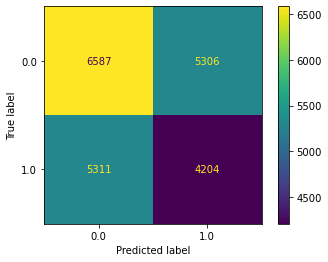

In [49]:
# Called function and printed out confusion and printed out Accuracy/Recall Score for DummyClassifier
confusion_and_metrics(dummy, X_test_smote, y_test_smote, y_test_pred)

Accuracy Score: 0.560
Precision Score: 0.506


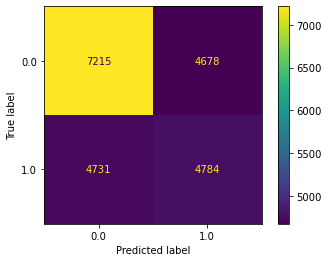

In [50]:
# Called function and printed out confusion matrix and metrics of iniital decision tree
confusion_and_metrics(dt, X_test_smote, y_test_smote, y_dt_test_pred)

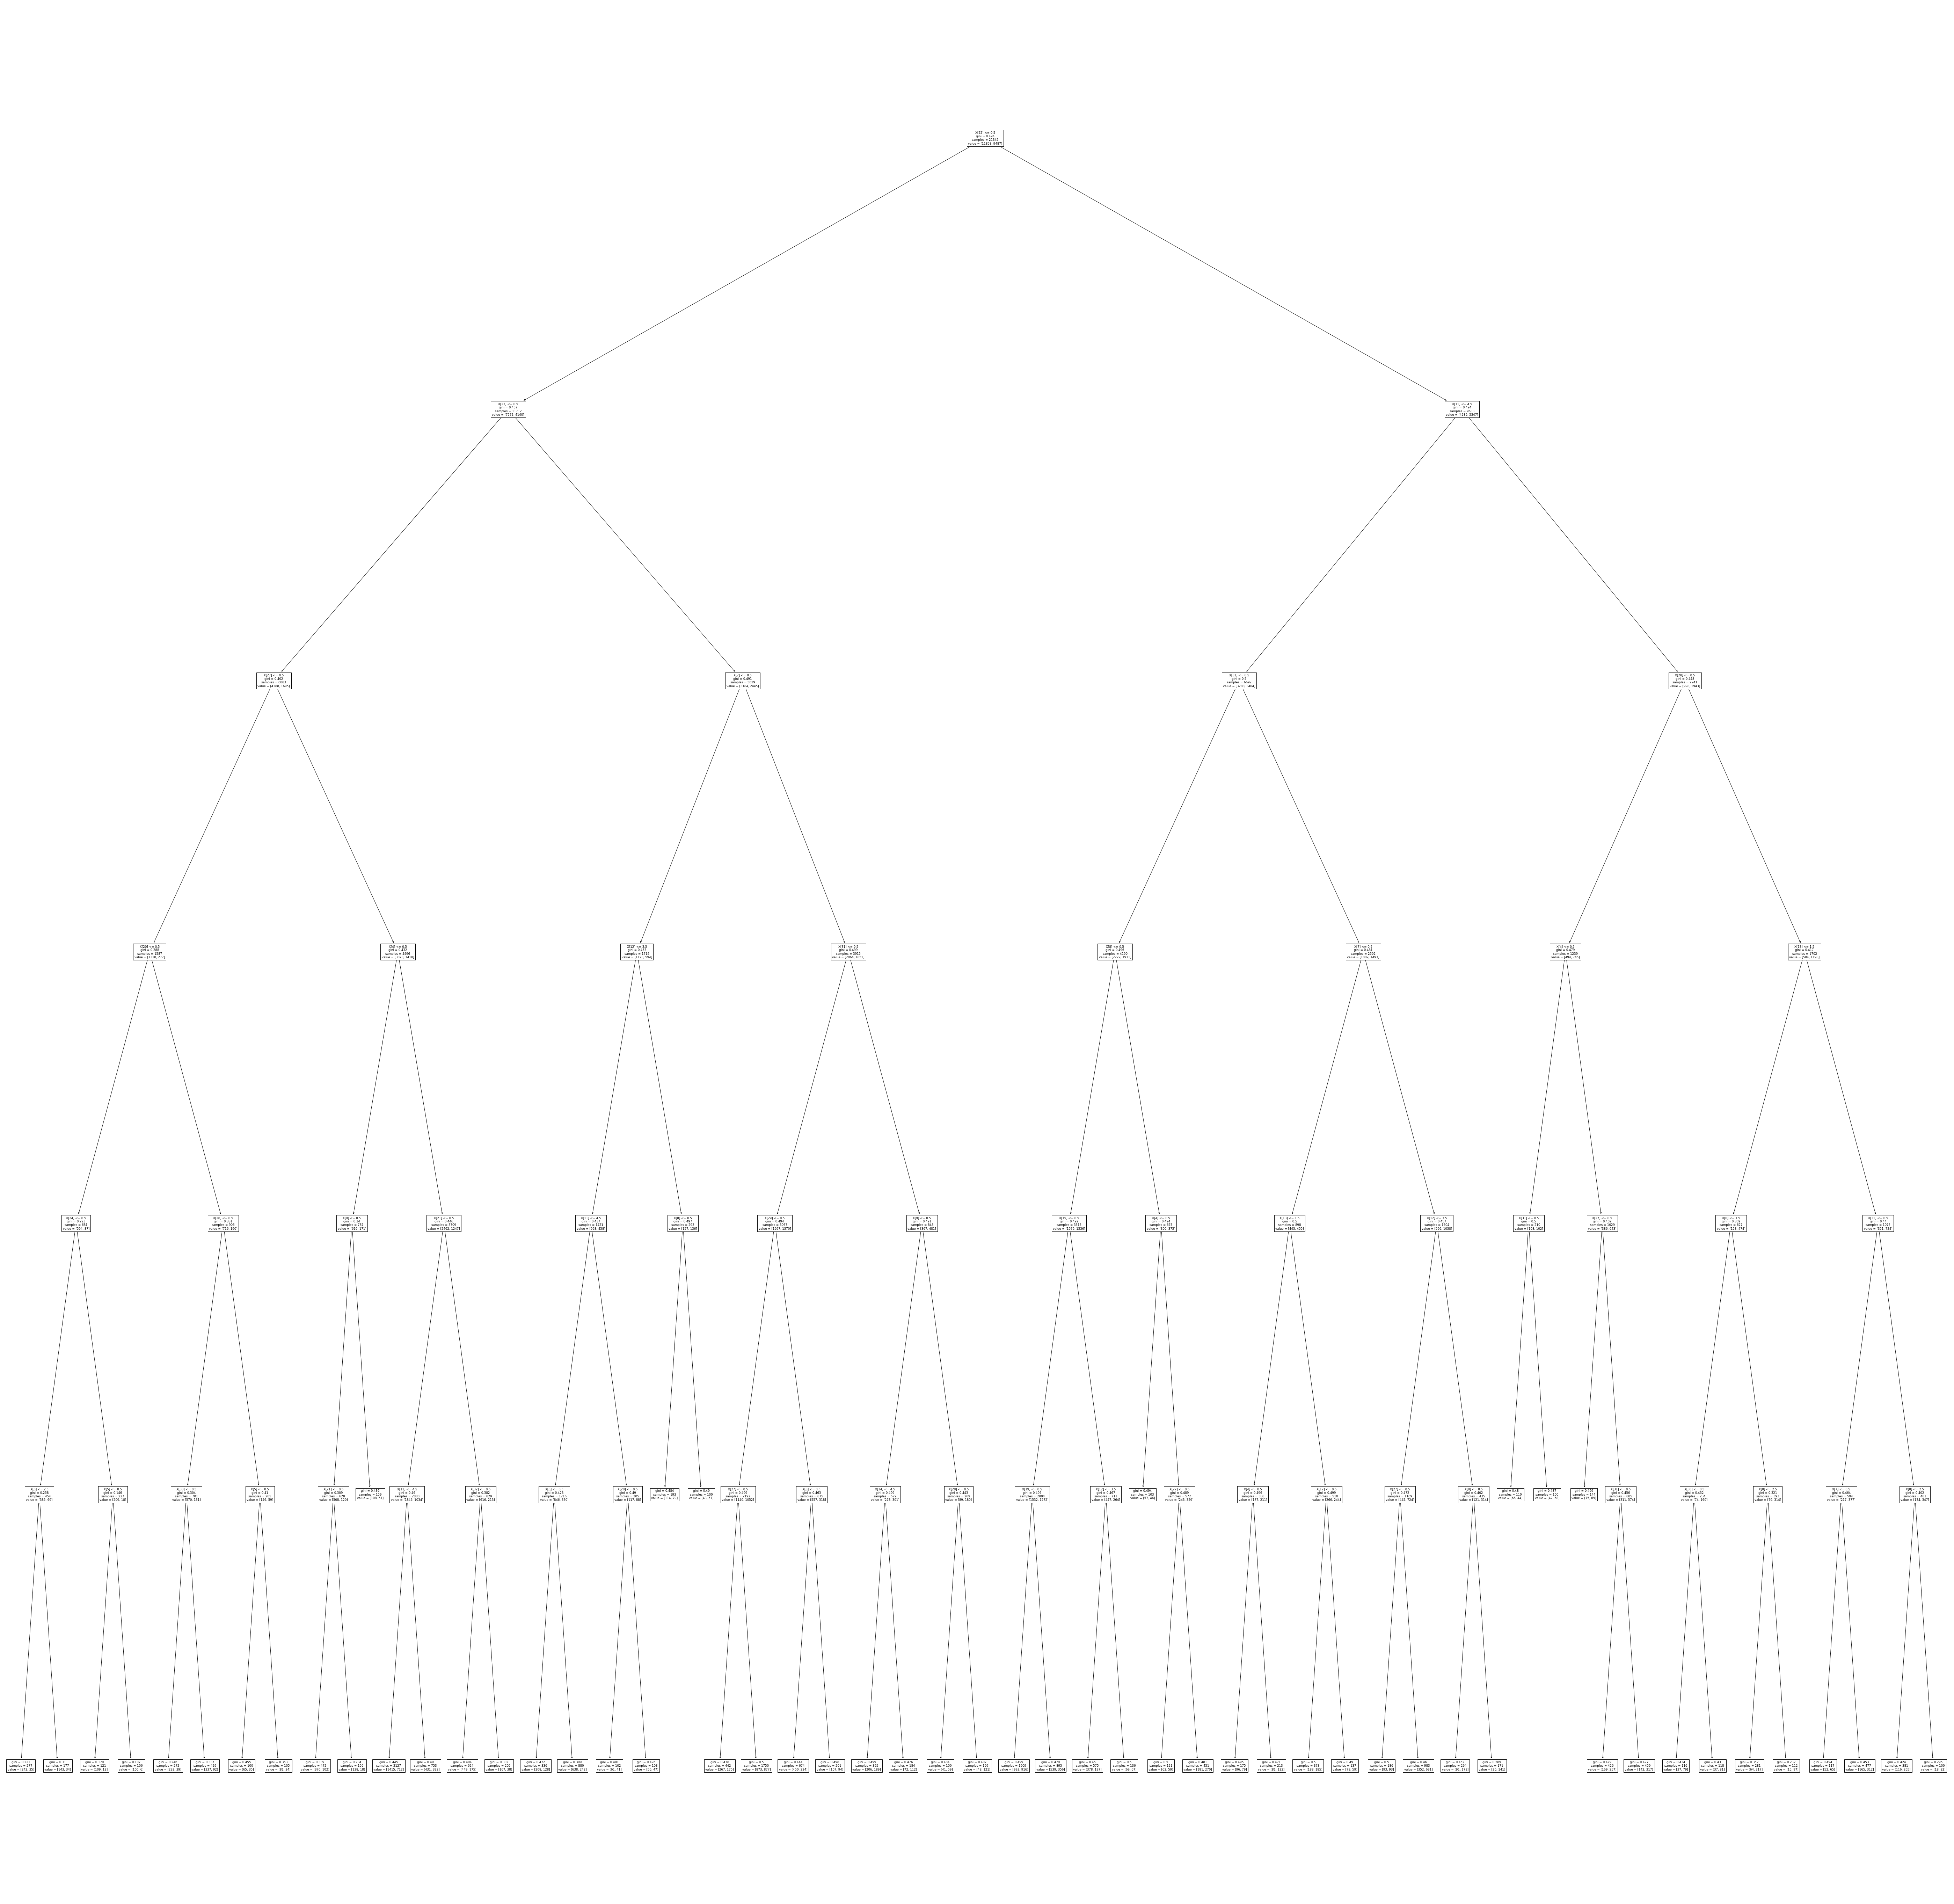

In [51]:
f, ax = plt.subplots(figsize=(100, 100))
plot_tree(dt2, ax=ax);
# plt.savefig('out.pdf')

Accuracy Score: 0.625
Precision Score: 0.506


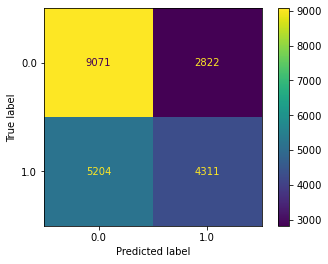

In [52]:
confusion_and_metrics(dt2, X_test_smote, y_test_smote, y_dt2_test_pred)

In [53]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_smote, y_smote)
y_lr_pred = model.predict(X_smote)
y_lr_test_pred = model.predict(X_test_smote)
model.score(X_test_smote, y_test_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6384529147982063

In [54]:
ohe_training_df.columns
# Those with an education of less than 12 years are 0.5x not as likely to get the vaccine and those with a below poverty income level are 0.7x less likely to get a vaccine 

Index(['h1n1_concern', 'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'age_group_18 - 34 Years',
       'age_group_35 - 44 Years', 'age_group_45 - 54 Years',
       'age_group_55 - 64 Years', 'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'race_Black', 'race_Hispanic',
       'race_Other or Multiple', 'race_White', 'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty', 'income_poverty_> $75,000',
       'income_poverty_Below Poverty'],
      dtype='object')

In [55]:
model_coef = pd.DataFrame(model.coef_)
print(np.exp(-0.342691))
model_coef
# Focus on whatever parameters make sense to our business problem (- = less likely to get vaccine, and thus need more information to combat this)

0.7098575236495536


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.024177,0.130783,0.001254,0.336023,0.223096,-0.02481,-0.094206,0.304372,0.237708,0.111823,0.045754,0.088617,0.078823,-0.076974,0.006246,-0.309794,-0.020641,0.109151,0.004656,-0.344387,-0.339372,-0.834029,0.502176,0.110209,-0.452,-0.201157,-0.078917,0.171059,-0.148644,-0.412371,-0.195561,0.157154,-0.522609


Accuracy Score: 0.638
Precision Score: 0.606


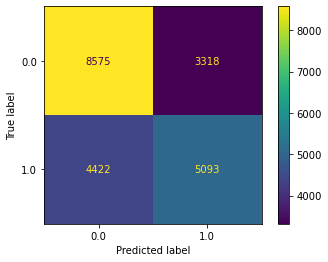

In [56]:
confusion_and_metrics(model, X_test_smote, y_test_smote, y_lr_test_pred)
# E to the value of this array to give us more odds and likelihood = easier to explain

In [57]:
grid2 = {
    'penalty': ['l1','l2','elasticnet'],
    'class_weight': ['balanced', 'None'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

gs2 = GridSearchCV(estimator = model, param_grid = grid2, cv = 5)
gs2.fit(X_smote, y_smote)

C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Beter\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Us

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'class_weight': ['balanced', 'None'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [58]:
gs2.best_params_

{'class_weight': 'None', 'penalty': 'l2', 'solver': 'newton-cg'}

In [59]:
model2 = LogisticRegression(random_state=42, penalty = 'l1', solver = 'saga')
model2.fit(X_smote, y_smote)
y_lr2_pred = model2.predict(X_smote)
y_lr2_test_pred = model2.predict(X_test_smote)
model2.score(X_test_smote, y_test_smote)

0.6388266068759342

Accuracy Score: 0.639
Precision Score: 0.606


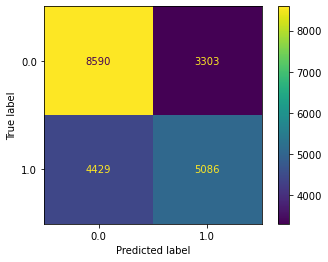

In [60]:
confusion_and_metrics(model2, X_test_smote, y_test_smote, y_lr2_test_pred)

[0.09612347 0.01407365 0.03702016 0.01792644 0.02240998 0.03742995
 0.03639933 0.025964   0.02029473 0.02952794 0.04183388 0.09817456
 0.09539662 0.10209446 0.08765667 0.01563486 0.01627863 0.01742726
 0.01753538 0.01508727 0.01170189 0.01276929 0.02517997 0.00857253
 0.00776735 0.00730297 0.00828531 0.01422545 0.01195302 0.01193883
 0.01099254 0.01646486 0.00855674]


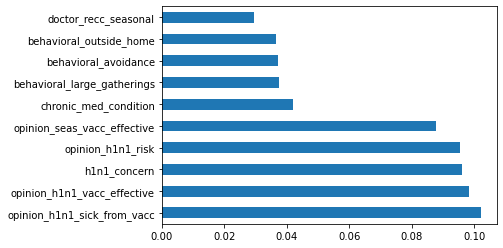

In [61]:
X = ohe_training_df.iloc[:,0:33]  #independent columns
y = vaccinetrainingdf.iloc[:,2]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
modelfeatures = ExtraTreesClassifier()
modelfeatures.fit(X,y)
print(modelfeatures.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(modelfeatures.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()